Import And Connection

In [36]:
import pyodbc as odbc
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DRIVER_NAME = 'ODBC Driver 17 for SQL Server'
SERVER_NAME = r'DESKTOP-L3GBMQ5\SQLEXPRESS'
DATABASE_NAME = 'Case_Studies'

connection_string = (
    f"DRIVER={{{DRIVER_NAME}}};"
    f"SERVER={SERVER_NAME};"
    f"DATABASE={DATABASE_NAME};"
    f"Trusted_Connection=yes;"
)

conn = odbc.connect(connection_string)
print("Connected successfully!")

Connected successfully!


-----------------------

Monthly Sales Trends

In [37]:
sql_trend = """
SELECT 
    order_year
    ,order_month
    ,SUM(total_sales) AS Total_Sales
FROM
    retail_sales_cleaned_3
GROUP BY
    order_year
    ,order_month
ORDER BY
    order_year
    ,order_month
"""

In [38]:
df_trend = pd.read_sql(sql_trend, conn)
df_trend

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_7672\3555986967.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_trend = pd.read_sql(sql_trend, conn)


,order_year,order_month,Total_Sales
0,NaN,NaN,107341.000252
1,2024.0,1.0,114601.496590
2,2024.0,2.0,137709.428528
3,2024.0,3.0,120799.045000
4,2024.0,4.0,127834.157349
5,2024.0,5.0,130109.092163
6,2024.0,6.0,127870.706154
7,2024.0,7.0,98606.600525
8,2024.0,8.0,142156.405975
9,2024.0,9.0,116686.956749


YoY Growth Rate

In [39]:
sql_yoy = """
WITH MonthlySales AS (
    SELECT 
        order_year
        ,order_month
        ,SUM(total_sales) AS Total_Sales
    FROM retail_sales_cleaned_3
    GROUP BY order_year, order_month
)
SELECT 
    order_year
    ,order_month
    ,Total_Sales
    ,LAG(Total_Sales, 12) OVER (ORDER BY order_year, order_month) AS Last_Year_Sales,
    CASE
        WHEN LAG(Total_Sales, 12) OVER (ORDER BY order_year, order_month) IS NULL 
            THEN NULL
        ELSE ((Total_Sales - LAG(Total_Sales, 12) OVER (ORDER BY order_year, order_month)) * 100.0 / 
              LAG(Total_Sales, 12) OVER (ORDER BY order_year, order_month))
    END AS YoY_Growth_Percent
FROM MonthlySales
ORDER BY order_year, order_month;
"""


In [40]:
df_yoy = pd.read_sql(sql_yoy, conn)
df_yoy.head(15)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_7672\1088254501.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_yoy = pd.read_sql(sql_yoy, conn)


,order_year,order_month,Total_Sales,Last_Year_Sales,YoY_Growth_Percent
0,NaN,NaN,107341.000252,NaN,NaN
1,2024.0,1.0,114601.496590,NaN,NaN
2,2024.0,2.0,137709.428528,NaN,NaN
3,2024.0,3.0,120799.045000,NaN,NaN
4,2024.0,4.0,127834.157349,NaN,NaN
5,2024.0,5.0,130109.092163,NaN,NaN
6,2024.0,6.0,127870.706154,NaN,NaN
7,2024.0,7.0,98606.600525,NaN,NaN
8,2024.0,8.0,142156.405975,NaN,NaN
9,2024.0,9.0,116686.956749,NaN,NaN


------------

Group & Prepare For Visualization

In [41]:
# Create Year-Month column for easier plotting
df_trend = df_trend.dropna(subset=["order_year", "order_month"])
df_trend["YearMonth"] = pd.to_datetime(
    df_trend["order_year"].astype(int).astype(str) + "-" +
    df_trend["order_month"].astype(int).astype(str).str.zfill(2) + "-01"
)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_7672\2218990340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trend["YearMonth"] = pd.to_datetime(


In [42]:
# Sort by date
df_trend = df_trend.sort_values("YearMonth")

In [43]:
# Rolling average (3 months)
df_trend['Sales_3M_Rolling'] = df_trend['Total_Sales'].rolling(3).mean()

------------------------

Visualization

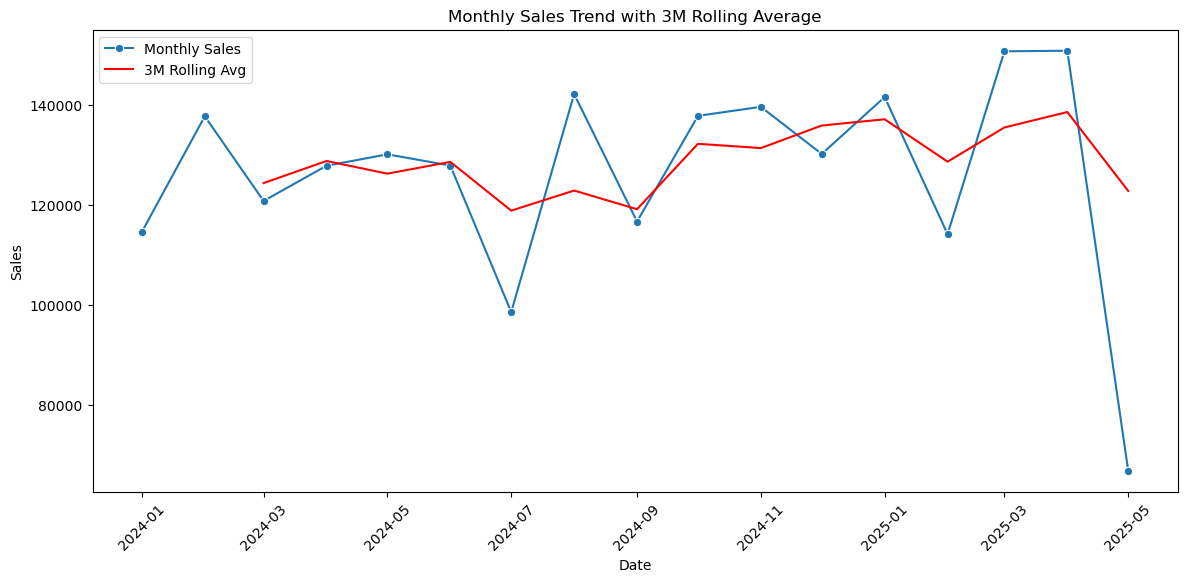

In [44]:
# Monthly Sales

plt.figure(figsize=(14,6))
sns.lineplot(data=df_trend, x="YearMonth", y="Total_Sales", marker="o", label="Monthly Sales")
sns.lineplot(data=df_trend, x="YearMonth", y="Sales_3M_Rolling", label="3M Rolling Avg", color="red")

plt.title("Monthly Sales Trend with 3M Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.show()

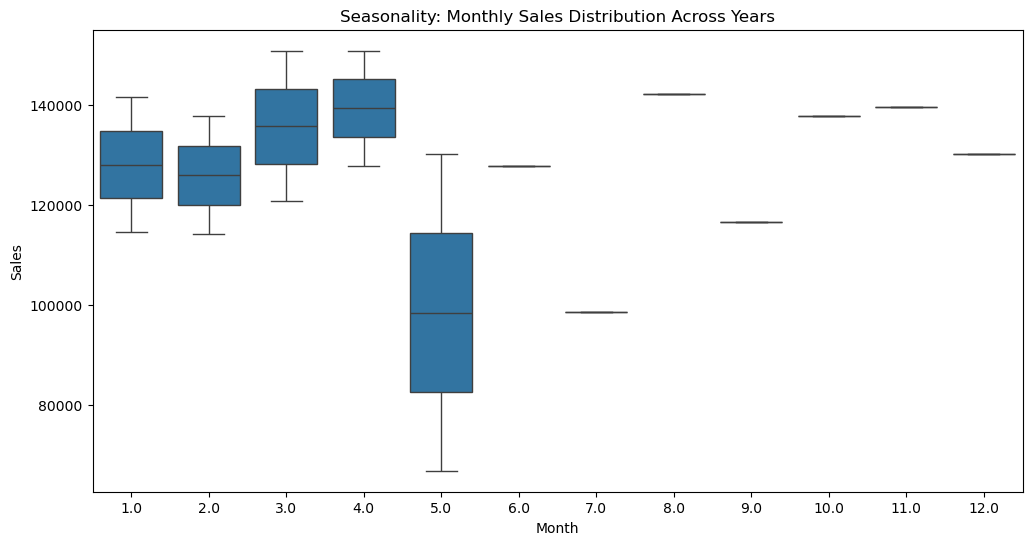

In [45]:
# Seasonable Spikes by Month
plt.figure(figsize=(12,6))
sns.boxplot(data=df_trend, x="order_month", y="Total_Sales")
plt.title("Seasonality: Monthly Sales Distribution Across Years")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

Highest & Lowest Months

In [46]:
highest_month = df_trend.loc[df_trend["Total_Sales"].idxmax()]
lowest_month = df_trend.loc[df_trend["Total_Sales"].idxmin()]

print("Highest Sales Month:", highest_month["YearMonth"].strftime("%Y-%m"), " → ", highest_month["Total_Sales"])
print("Lowest Sales Month:", lowest_month["YearMonth"].strftime("%Y-%m"), " → ", lowest_month["Total_Sales"])

Highest Sales Month: 2025-04  →  150805.65405273438
Lowest Sales Month: 2025-05  →  66914.59753417969


In [ ]:
# Save final cleaned + enriched dataset into SQL Server
df_trend.to_excel("monthly_sales_trend.xlsx", index=False)
df_yoy.to_excel("yoy.xlsx", index=False)

In [51]:
df = """
SELECT * FROM retail_sales_cleaned_3
"""

In [53]:
df = pd.read_sql(df, conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_7672\1367799169.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(df, conn)


In [54]:
df

,order_id,order_date,customer_id,customer_name,region,product_category,product_name,quantity,unit_price,discount,total_sales,payment_method,delivery_status,order_year,order_month,segment,state
0,O-1000,2024-01-01,C-208,Jane Smith,South,Furniture,T-Shirt,10,805.520020,00:01:00,7974.647949,Credit Card,Pending,2024.0,1.0,Medium,Texas
1,O-1001,2024-01-02,C-365,Ali Hassan,North,Furnitre,Sofa,3,1550.010010,00:25:00,3487.522461,Cash,Cancelled,2024.0,1.0,Low,Unknown
2,O-1002,2024-01-03,C-498,Jane Smith,West,Furniture,Laptop,1,1187.380005,00:10:00,1068.641968,Bank Transfer,Pending,2024.0,1.0,Low,California
3,O-1003,2024-01-04,C-371,Ali Hassan,East,Electronics,Headphones,2,932.390015,00:07:00,1734.245361,Cash,Cancelled,2024.0,1.0,Low,New York
4,O-1004,2024-01-05,C-218,Jane Smith,West,Clothing,Sofa,10,279.369995,00:17:00,2318.770996,Cash,Returned,2024.0,1.0,Low,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,O-1374,2025-01-09,C-830,Unknown,North,Clothing,Table,7,1876.189941,00:17:00,10900.664062,Bank Transfer,Pending,2025.0,1.0,High,Unknown
477,O-1155,2024-06-04,C-424,Unknown,West,Clothing,Sofa,1,322.160004,00:07:00,299.608795,Bank Transfer,Pending,2024.0,6.0,Medium,California
478,O-1104,2024-04-14,C-518,Unknown,East,Clothing,Laptop,7,1339.459961,00:08:00,8626.122070,Bank Transfer,Delivered,2024.0,4.0,High,New York
479,O-1394,2025-01-29,C-641,Unknown,East,Other,Rice Bag,8,1392.670044,00:30:00,7798.952148,Credit Card,Returned,2025.0,1.0,High,New York


In [56]:
df.to_excel("df.xlsx", index=False)